# notes

$$a_1 \equiv 1 - h_i^{guess}\partial_{x}F|_{\left(t_{i},x_{i}\right)}$$

$$a_2 \equiv 1 - h_i^{guess}\partial_{x}F|_{\left(t_{i}+h_{i}^{guess},x_{i}\right)}$$


$a_1$ and $a_2$ should be positive.

### [DONE] if `_dxFx_tixi` is negative, then, no need to find `hi`, since it doesn't really matter; it is always stable .. 
### -> may be not, think of a possibility for a bifurcation can happen

### [DONE] Use linear treament just for hi stepsize control, and use pure Newton rapson method to find the proper $x_{i+1}$. --> other method such as `hybrid` wrapped in `scipy.optimize.root()` may be used

### Implement backward propagation

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from numbers import Real

def get_stepsize(ti, xi, Fx, dxFx, hi_max,
                gamma = 0.8, hi_min = 0.005, forward=True):
    """ 
    An appropreiate stepsize is estimated 
    where the implicit Euler method may work.
    
    # Arguments
    - `ti`: given time point
    - `xi`: x(ti), given value at given time point `ti`
    - `Fx`: 'F(x,t)=dx(t)/dt', time derivative of function 'x(t)'
    - `dxFx`: 'x' derivative of `Fx`
    - `hi_max`: upper bound of stepsize
    - `gamma`: 0 < float < 1
    - `hi_min`: lower bound of stepsize
    - `forward`: time direction. the timestep is positive when `forward==True`
    """
    
    if not forward: raise NotImplementedError(
        "backward time flow hasn't been dealt yet")
    assert isinstance(gamma, Real) and (0 < gamma) and (gamma < 1)
    
    _hi_guess = None
    
    _dxFx_tixi = dxFx(ti, xi)
    if _dxFx_tixi > 0: _hi_guess = min(gamma / _dxFx_tixi, hi_max)
    else: _hi_guess = hi_max
    assert isinstance(_hi_guess, Real)
    assert (1 - _hi_guess * _dxFx_tixi) > 0
    
    _a2 = None
    while _hi_guess > hi_min:
        _a2 = 1 - _hi_guess * dxFx(ti+_hi_guess, xi)
        if _a2 > 0: break
        _hi_guess *= gamma
    if (_hi_guess <= hi_min): raise Exception("hi_min reached - couldn't find good stepsize")
    _hi = _hi_guess
    
    return _hi

# [DONE, by using MINPACK wrapper] try other fzero method also, such as bisection (for overcoming oscillation) .. and considering higher dimension, .. some general method -- consider the MATLAB etc. fzero algorithem

In [3]:
import numpy as np
from scipy.optimize import root

def back_euler(t0, x0, t_max, Fx, dxFx, hi_max, **stepsize_kwarg):
    _t_list = [t0]
    _x_list = [x0]

    while _t_list[-1] < t_max:
        _ti, _xi = _t_list[-1], _x_list[-1]
        _hi = get_stepsize(_ti, _xi, Fx, dxFx, hi_max, **stepsize_kwarg)
        _t_next = _ti + _hi
        def _Gx(x): return (x - _xi) - _hi * Fx(_t_next, x)
        _sol = root(_Gx, _xi)  # jacobian may be supplied
        if _sol.success and _sol.x.size == 1: _x_next, = _sol.x
        else: raise Exception("unique root search failed due to '{}'".format(_sol.message))
        _t_list.append(_t_next), _x_list.append(_x_next)
    
    _t_arr, _x_arr = np.array(_t_list), np.array(_x_list)
    return _t_arr, _x_arr

In [4]:
from bohm.ode.euler import back_euler

In [5]:
def Fx(t, x): return 3.0*x
def dxFx(t, x): return 3.0

t0, x0 = 0.2, -1.1
t_max = 3.0

In [6]:
t_arr, x_arr = back_euler(t0, x0, t_max, Fx, dxFx, hi_max=0.1)

In [7]:
f_arr = x0 * np.exp(3.0 * (np.array(t_arr) - t0))

(-1000, 0)

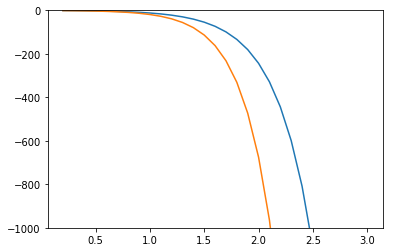

In [8]:
fig, ax = plt.subplots()

ax.plot(t_arr, f_arr)
ax.plot(t_arr, x_arr)
ax.set_ylim(-1000,0)

In [9]:
# fig.savefig("implicit-euler-k-3-h-0.1-stepsize-controlled-test-0.png")

# etc. routine

In [10]:
def iter_newton(ti, xi, hi, Fx, dxFx, thres=1e-10, N_itermax=10):
    _x = xi
    _t_next = ti + hi
    _x_converged = False
    for _i in range(N_itermax):
        _Gx = (_x - xi) - hi * Fx(_t_next, _x)
        _dxGx = 1.0 - hi * dxFx(_t_next, _x)
        assert _dxGx != 0
        _x_next = _x - _Gx / _dxGx
        _x_converged = abs(_x_next - _x) < thres
        print("_x_next - _x: {}".format(_x_next - _x))
        if _x_converged: break
        _x = _x_next
    if not _x_converged or (_i >= N_itermax - 1): 
        raise Exception("convergence might have been failed")
    return _x_next